In [1]:
pip install librosa pydub numpy pandas matplotlib

In [2]:
pip install noisereduce

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import librosa
import wave
import noisereduce as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import audioread

### Loading audio files

In [2]:
# Define the path to the dataset
mp3_folder_path = 'C:\\Users\\Kunal T\\OneDrive\\Documents\\EmoDetect_Sneha\\CREMA-D\\AudioMP3'
wav_folder_path = 'C:\\Users\\Kunal T\\OneDrive\\Documents\\EmoDetect_Sneha\\CREMA-D\\AudioWAV'

# Get a list of audio file paths
def get_audio_files(directory, extensions=['.mp3', '.wav']):
    audio_files = []
    for root, _, files in os.walk(directory):
        for file in files:
             if any(file.endswith(ext) for ext in extensions):
                audio_files.append(os.path.join(root, file))
    return audio_files

# Get all audio file paths
mp3_files = get_audio_files(mp3_folder_path, extensions=['.mp3'])
wav_files = get_audio_files(wav_folder_path, extensions=['.wav'])

# Combine both lists of audio files
audio_files = mp3_files + wav_files

# Display the number of files loaded
print(f"Total .mp3 files found: {len(mp3_files)}")
print(f"Total .wav files found: {len(wav_files)}")
print(f"Total audio files found: {len(audio_files)}")

Total .mp3 files found: 7442
Total .wav files found: 7442
Total audio files found: 14884


In [5]:
pip install soundfile

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade librosa

Note: you may need to restart the kernel to use updated packages.


### Handling missing values and checking for corrupted files

In [3]:
from pydub import AudioSegment

In [4]:
# Function to load audio files with error handling
def load_audio(file_path, target_sample_rate=16000):
    try:
        with audioread.audio_open(file_path) as input_file:
            audio, sr = librosa.load(file_path, sr=target_sample_rate)
            return audio, sr
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# Function to get all audio files
def get_audio_files(directory, extensions=['.mp3', '.wav']):
    audio_files = []
    for root, _, files in os.walk(directory):
        for file in files:
             if any(file.endswith(ext) for ext in extensions):
                audio_files.append(os.path.join(root, file))
    return audio_files

# Get all audio files from both folders
mp3_files = get_audio_files(mp3_folder_path, extensions=['.mp3'])
wav_files = get_audio_files(wav_folder_path, extensions=['.wav'])
audio_files = mp3_files+wav_files

# Lists to store clean audio data and corrupted files
cleaned_audio_data = []
corrupted_files = []

# Process and clean all audio files
for file_path in audio_files:
    cleaned_audio, sr = load_audio(file_path, target_sample_rate=16000)
    if cleaned_audio is not None:
        cleaned_audio_data.append(cleaned_audio)
    else:
        corrupted_files.append(file_path)

# Display summary
print(f"Total audio files processed: {len(audio_files)}")
print(f"Total cleaned audio files: {len(cleaned_audio_data)}")
print(f"Total corrupted files: {len(corrupted_files)}")

# Optionally: log corrupted files
if corrupted_files:
    with open('corrupted_files_log.txt', 'w') as log_file:
        for file in corrupted_files:
            log_file.write(file + '\n')
    print(f"Corrupted files log saved as 'corrupted_files_log.txt'")
else:
    print("No corrupted files found.")

Total audio files processed: 14884
Total cleaned audio files: 14884
Total corrupted files: 0
No corrupted files found.


### Removing silence or bg noise

In [6]:
# Remove silence from the audio
def remove_silence(audio_data, sample_rate, top_db=20):
    # Trim silence from the beginning and end
    trimmed_data, _ = librosa.effects.trim(audio_data, top_db=top_db)
    return trimmed_data

# Normalize the audio (bg noise)
def normalize_audio(audio_data):
    normalized_data = librosa.util.normalize(audio_data)
    return normalized_data

# Clean audio: silence removal, noise reduction, and normalization
def clean_audio(file_path):
    try:
        # Load the audio file
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        # Remove silence
        audio_data = remove_silence(audio_data, sample_rate)

        # Apply noise reduction
        reduced_noise = nr.reduce_noise(y=audio_data, sr=sample_rate)

        # Normalize audio to ensure consistent loudness
        normalized_audio = normalize_audio(reduced_noise)

        # Return cleaned audio and sample rate
        return normalized_audio, sample_rate

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None
    

### Normalizing audio length

In [7]:
def pad_audio(audio_data, sample_rate, duration=2.0):
    # Calculate the target number of samples for the specified duration
    target_length = int(sample_rate * duration)
    # Pad or trim the audio to match the target length
    if len(audio_data) > target_length:
        return audio_data[:target_length]
    else:
        return np.pad(audio_data, (0, target_length - len(audio_data)), 'constant')


### Visualize the audio data

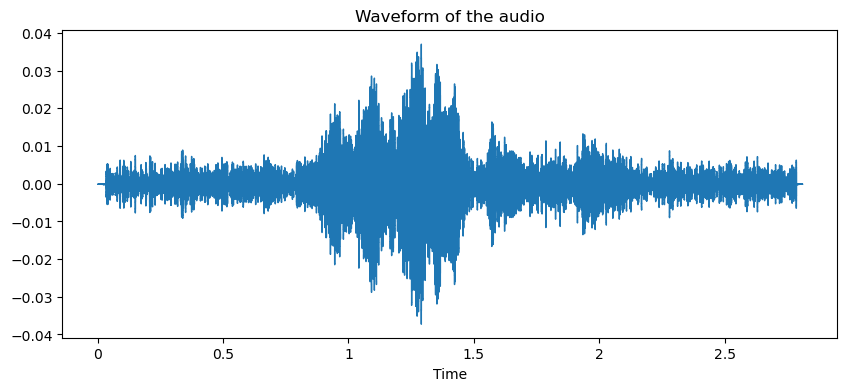

Audio file name: C:\Users\Kunal T\OneDrive\Documents\EmoDetect_Sneha\CREMA-D\AudioMP3\1009_IWW_SAD_XX.mp3


In [8]:
def plot_waveform(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sample_rate)
    plt.title('Waveform of the audio')
    plt.show()

# Plot the waveform of a sample audio file
plot_waveform(audio_files[700])
print("Audio file name:",audio_files[700])

### Extract audio features

In [9]:
def extract_features(file_path):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # Extract MFCCs (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    # Take the mean of MFCCs over time
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    # Extract Chroma Features
    stft = np.abs(librosa.stft(audio_data))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    chroma_mean = np.mean(chroma.T, axis=0)
        
    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
    spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)
    
    # Extract Root Mean Square Energy (RMSE)
    rmse = librosa.feature.rms(y=audio_data)
    rmse_mean = np.mean(rmse.T, axis=0)
    
    # Combine features into a single array
    features = np.hstack((mfccs_mean, spectral_contrast_mean, rmse_mean))
    
    return features

# Test the feature extraction on one file
sample_features = extract_features(audio_files[0])
print(f"Extracted features shape: {sample_features.shape}")
# Print the actual feature values
print("Extracted feature values:", sample_features)

Extracted features shape: (48,)
Extracted feature values: [-4.66044037e+02  1.50633331e+02 -9.94114280e-01  1.86096973e+01
  1.61165581e+01  1.60749474e+01 -5.09173632e+00 -5.62417364e+00
 -1.87049925e+00 -1.75249290e+01  2.75197911e+00 -3.26697159e+00
 -1.43382063e+01  7.20131099e-01 -6.10115647e-01 -1.04393101e+01
 -5.69911242e+00  5.81940842e+00 -5.95525408e+00 -1.34294395e+01
  1.86037198e-01 -5.69904745e-01 -7.14885902e+00 -4.27380228e+00
 -5.18052959e+00 -5.56034088e+00 -3.66841435e+00 -5.56168890e+00
 -3.05412841e+00 -2.13752484e+00 -1.24923027e+00 -1.15469718e+00
 -4.19836378e+00 -4.05553639e-01 -1.88021517e+00 -2.00008273e+00
 -8.24975967e-01 -2.52311611e+00  4.78549600e-01 -2.53101921e+00
  1.92400019e+01  1.08282259e+01  1.48331849e+01  1.58417786e+01
  2.06759964e+01  2.72323465e+01  5.40826332e+01  1.94405783e-02]


In [10]:
# checking if any file is empty or incorrect
def load_audio(file_path, target_sample_rate=16000):
    try:
        with audioread.audio_open(file_path) as input_file:
            audio, sr = librosa.load(file_path, sr=target_sample_rate)
            if len(audio) == 0:
                print(f"Warning: Loaded audio is empty from {file_path}")
                return None, None
            return audio, sr
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None


### Checking if SAD files are present

In [11]:
#Check File Names for 'SAD'

# Count the number of files labeled as "SAD"
sad_files_count = len([file for file in audio_files if "SAD" in file.upper()])  # Adjusting to uppercase to avoid case sensitivity issues

# Print the total count of "SAD" files
print(f"Total number of files labeled as 'SAD': {sad_files_count}")

Total number of files labeled as 'SAD': 2542


### Label extraction and dataframe for model input

In [12]:
def get_label(file_path):
    # Assuming the label is the part of the file name
    file_name = os.path.basename(file_path)
    # The emotion label is the third part (index 2) after splitting by underscores
    label = file_name.split('_')[2].strip().upper() 
    #print(f"Extracted label: {label} from {file_name}")
    return label

In [13]:
features = []
labels = []

print(f"Total audio files to process: {len(audio_files)}")

for file in audio_files:
    features.append(extract_features(file))
    labels.append(get_label(file))


Total audio files to process: 14884


C:\Users\Kunal T\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [14]:
# Create a DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels

# Display the first few rows
print(features_df.head())

unique_labels = features_df['label'].unique()
print(f"\nUnique labels extracted: {unique_labels}")

            0           1          2          3          4          5  \
0 -466.044037  150.633331  -0.994114  18.609697  16.116558  16.074947   
1 -514.860657  159.774277 -11.262385  32.615177  13.642810  27.783012   
2 -468.490845  128.115448   7.930116  17.409929  14.585181  18.754990   
3 -465.272675  145.044220  -3.409719  17.591787  18.319963  19.420616   
4 -490.461060  144.079315   7.913373  15.532048  22.751905  17.330116   

          6          7         8          9  ...        39         40  \
0 -5.091736  -5.624174 -1.870499 -17.524929  ... -2.531019  19.240002   
1 -3.117455  -5.257946  3.839833 -13.651824  ... -1.694973  17.244169   
2 -3.237400  -6.421238 -0.455285 -10.519911  ...  0.817884  18.388017   
3 -6.571012 -10.178814  0.110154 -13.145903  ... -1.320237  18.870542   
4 -1.515759  -2.500594 -1.674686 -12.323693  ... -0.764155  17.026882   

          41         42         43         44         45         46        47  \
0  10.828226  14.833185  15.841779  20.67

In [15]:
print(features_df)

                0           1          2          3          4          5  \
0     -466.044037  150.633331  -0.994114  18.609697  16.116558  16.074947   
1     -514.860657  159.774277 -11.262385  32.615177  13.642810  27.783012   
2     -468.490845  128.115448   7.930116  17.409929  14.585181  18.754990   
3     -465.272675  145.044220  -3.409719  17.591787  18.319963  19.420616   
4     -490.461060  144.079315   7.913373  15.532048  22.751905  17.330116   
...           ...         ...        ...        ...        ...        ...   
14879 -413.367371   96.386276  46.369541  14.591498  20.041859  10.173371   
14880 -426.014099   91.230385  49.762833  20.573891  22.044111  11.756287   
14881 -370.487915   90.638107  38.969696  19.762011  14.836708   0.329150   
14882 -393.181244   94.353287  45.251865  12.303625  12.717791   8.813283   
14883 -428.943237   95.965904  47.516315  18.359037  19.929518  10.473203   

              6          7         8          9  ...        39         40  

### Preparing data (x,y) and test-train split

In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode the labels to numerical values
label_encoder = LabelEncoder()
features_df['label'] = label_encoder.fit_transform(features_df['label'])

# Split features and labels
X = features_df.drop('label', axis=1)
y = features_df['label']

# Normalize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (11907, 48), Test set size: (2977, 48)


### Training the model

In [17]:
#SVM

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")



SVM Model Accuracy: 43.67%


In [18]:
# Random Forest 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

Random Forest Model Accuracy: 45.38%


In [19]:
# Graadient Boost

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Model Accuracy: {accuracy * 100:.2f}%")


Gradient Boosting Model Accuracy: 47.93%


In [36]:
# Using a voting classifier with Random Forest and Gradient Boosting

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Combine Random Forest and Gradient Boosting in an ensemble
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the accuracy
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy * 100:.2f}%")


Ensemble Model Accuracy: 46.42%


In [33]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/e2/7b/8c1b410cd0604cee9a167a19f7e1746f5b92ae7d02ad574ab560b73c5a48/xgboost-2.1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 991.0 kB/s eta 0:02:06
   ---------------------------------------- 0.6/124.9 MB 5.4 MB/s eta 0:00:24
   ---------------------------------------- 1.5/124.9 MB 9.5 MB/s eta 0:00:13
    --------------------------------------- 2.7/124.9 MB 13.3 MB/s eta 0:00:10
   - -------------------------------------- 3.7/124.9 MB 14.7 MB/s eta 0:00:09
   - -------------------------------------- 4.3/124.9 MB 14.5 MB/s eta 0:00:09
   - -------------------------------------- 4.9/124.9 MB 14.2 MB/s eta 0:00:09
   - -------------------------------------- 5.5/124.9 MB 14.0 MB/s eta 0:00:09
   - -----------------

In [73]:
# XGBoost

import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy * 100:.2f}%")


XGBoost Model Accuracy: 44.51%


In [20]:
pip install tensorflow

In [32]:
pip install --upgrade tensorflow

In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Kunal T\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [21]:
# CNN
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,Input, BatchNormalization

# Build the CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    
    # Explicitly define the input layer with the correct shape for CNN
    model.add(Input(shape=input_shape))  # Reshape input to (timesteps, 1)

    # 1st Convolutional layer
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # 2nd Convolutional layer
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer (for emotion classification)
    model.add(Dense(6, activation='softmax'))  # Assuming 6 emotion classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Input shape (for example, if your features have 48 dimensions)
input_shape = (X_train.shape[1], 1)  # 48 features (MFCC, spectral contrast, RMSE), reshape to fit CNN input

cnn_model = create_cnn_model(input_shape)

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2907 - loss: 2.0077 - val_accuracy: 0.3561 - val_loss: 1.5429
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3709 - loss: 1.5149 - val_accuracy: 0.4125 - val_loss: 1.4244
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4132 - loss: 1.4223 - val_accuracy: 0.4330 - val_loss: 1.3938
Epoch 4/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4339 - loss: 1.3833 - val_accuracy: 0.4444 - val_loss: 1.3769
Epoch 5/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4467 - loss: 1.3418 - val_accuracy: 0.4424 - val_loss: 1.3657
Epoch 6/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4807 - loss: 1.2851 - val_accuracy: 0.4518 - val_loss: 1.3502
Epoch 7/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4768 - loss: 1.2825 - val_accuracy: 0.4612 - val_loss: 1.3568
Epoch 8/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5025 - loss: 1.2341 - val_accuracy: 0.

Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7335 - loss: 0.6729 - val_accuracy: 0.4709 - val_loss: 1.7155
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7257 - loss: 0.6690 - val_accuracy: 0.4726 - val_loss: 1.6805
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7253 - loss: 0.6655 - val_accuracy: 0.4662 - val_loss: 1.7926
Epoch 4/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7365 - loss: 0.6651 - val_accuracy: 0.4730 - val_loss: 1.7511
Epoch 5/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7458 - loss: 0.6253 - val_accuracy: 0.4773 - val_loss: 1.8193
Epoch 6/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7362 - loss: 0.6377 - val_accuracy: 0.4632 - val_loss: 1.8014
Epoch 7/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7518 - loss: 0.6182 - val_accuracy: 0.4726 - val_loss: 1.8538
Epoch 8/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7535 - loss: 0.5975 - val_accuracy: 0.

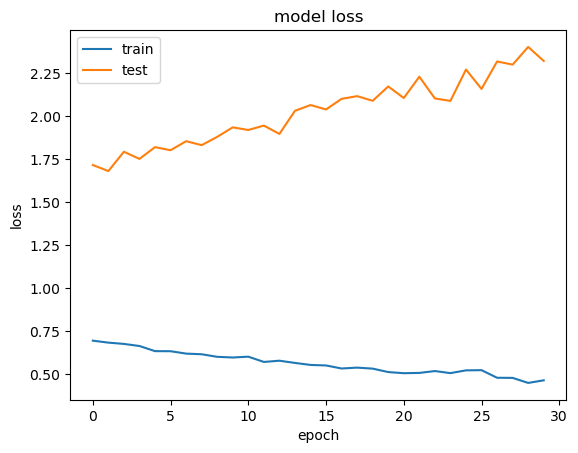

In [23]:
cnnhistory = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

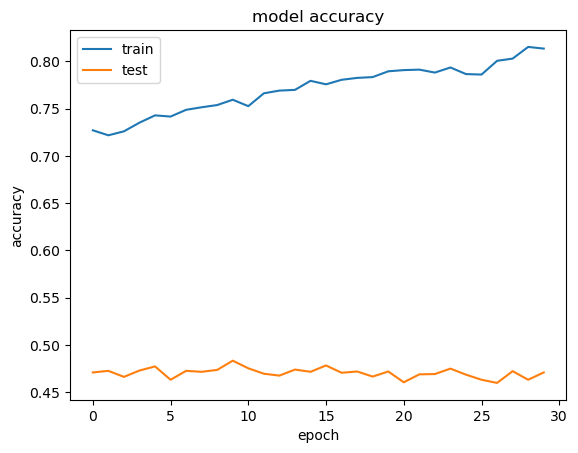

In [24]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

### Number of features extracted

In [34]:
print(f'Features extracted:{X_train.shape[1]}')

Features extracted:48


### Results

In [34]:
# Gradient Boost

# Convert to DataFrame for easier handling (optional)
features_df = pd.DataFrame(features)
labels_df = pd.Series(labels)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)

# Load your trained model

#rf_model = RandomForestClassifier()

#svm_model = SVC()


gb_model = GradientBoostingClassifier()

# Train (fit) the model
gb_model.fit(X_train, y_train)

# Make predictions
predictions = gb_model.predict(features_df)

# Show real vs predicted values
results_df = pd.DataFrame({
    'True Label': labels,
    'Predicted Label': predictions
})

# Display the results
print(results_df)

# Optionally save to a CSV file
#results_df.to_csv('emotion_detection_results.csv', index=False)

      True Label Predicted Label
0            ANG             ANG
1            DIS             DIS
2            FEA             ANG
3            HAP             HAP
4            NEU             HAP
...          ...             ...
14879        DIS             DIS
14880        FEA             FEA
14881        HAP             DIS
14882        NEU             DIS
14883        SAD             SAD

[14884 rows x 2 columns]


In [24]:
# SVM

# Convert to DataFrame for easier handling (optional)
features_df = pd.DataFrame(features)
labels_df = pd.Series(labels)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)

# Load your trained model

#rf_model = RandomForestClassifier()

svm_model = SVC()

#gb_model = GradientBoostingClassifier()

# Train (fit) the model
svm_model.fit(X_train, y_train)

# Make predictions
predictions = svm_model.predict(features_df)

# Show real vs predicted values
results_df = pd.DataFrame({
    'True Label': labels,
    'Predicted Label': predictions
})

# Display the results
print(results_df)

# Optionally save to a CSV file
#results_df.to_csv('emotion_detection_results.csv', index=False)

      True Label Predicted Label
0            ANG             HAP
1            DIS             HAP
2            FEA             HAP
3            HAP             HAP
4            NEU             HAP
...          ...             ...
14879        DIS             SAD
14880        FEA             SAD
14881        HAP             FEA
14882        NEU             SAD
14883        SAD             SAD

[14884 rows x 2 columns]


In [22]:
# CNN

# Make predictions on the test set
predictions = cnn_model.predict(X_test)

# Get the predicted label indices (i.e., the class with the highest probability)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true label indices from the one-hot encoded y_test
true_labels = y_test

# Show real vs predicted values for the test set
results_df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

# Display the results
print(results_df)

# Optionally, calculate and display the accuracy of the CNN model
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"CNN Model Accuracy: {accuracy * 100:.2f}%")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
       True Label  Predicted Label
10937           0                3
5219            2                2
3745            4                4
7639            0                0
2301            2                2
...           ...              ...
10655           0                1
4026            5                5
3059            4                4
8119            0                2
11807           4                4

[2977 rows x 2 columns]
CNN Model Accuracy: 46.46%


### Model Performance Comparison

In [29]:
import tensorflow as tf

In [33]:
# Store the accuracies of the three models
svm_accuracy = svm_model.score(X_test, y_test) * 100  # SVM accuracy
gb_accuracy = gb_model.score(X_test, y_test) * 100  # Gradient Boost accuracy
cnn_accuracy = cnn_model.evaluate(X_test, y_test)[1] * 100  # CNN accuracy (evaluates on validation data)

# Print individual model accuracies
print(f"SVM Accuracy: {svm_accuracy:.2f}%")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}%")
print(f"CNN Accuracy: {cnn_accuracy:.2f}%")

UnimplementedError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Kunal T\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Kunal T\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Kunal T\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Kunal T\AppData\Local\Temp\ipykernel_34796\1216031517.py", line 4, in <module>

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 433, in evaluate

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 165, in one_step_on_iterator

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in one_step_on_data

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 85, in test_step

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 359, in _compute_loss

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 327, in compute_loss

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 611, in __call__

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 652, in call

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\losses\loss.py", line 56, in __call__

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\tree\tree_api.py", line 148, in map_structure

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\tree\optree_impl.py", line 79, in map_structure

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\optree\ops.py", line 747, in tree_map

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\losses\loss.py", line 57, in <lambda>

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\ops\core.py", line 822, in convert_to_tensor

  File "C:\Users\Kunal T\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/sparse_categorical_crossentropy/Cast}}]] [Op:__inference_one_step_on_iterator_49411]

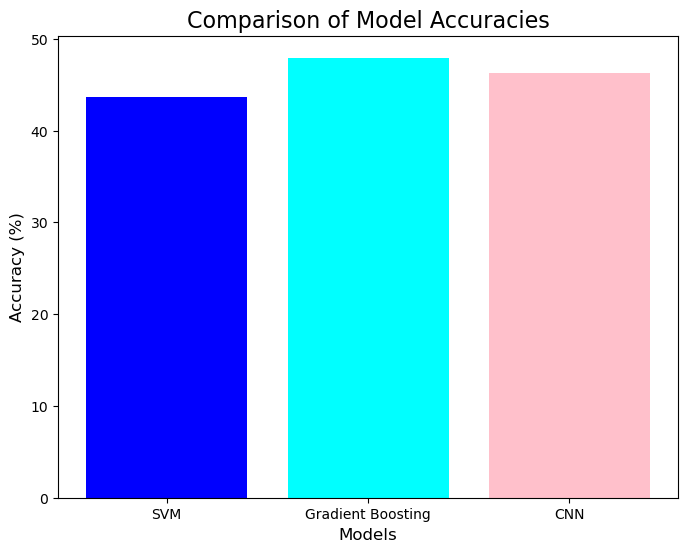

In [112]:
import matplotlib.pyplot as plt

# Create a list of model names
model_names = ['SVM', 'Gradient Boosting', 'CNN']

# Create a list of the accuracies from your models
accuracies = [svm_accuracy, gb_accuracy, cnn_accuracy]

# Plot the accuracies using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'cyan', 'pink'])

# Add title and labels
plt.title('Comparison of Model Accuracies', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)

# Show the plot
plt.show()

### Comparative table

In [113]:
svm_accuracy = svm_model.score(X_test, y_test) * 100  
gb_accuracy = gb_model.score(X_test, y_test) * 100
cnn_accuracy = cnn_model.evaluate(X_test, y_test)[1] * 100

# Create a dictionary with model names and their corresponding accuracies
accuracy_dict = {
    'Model': ['SVM', 'Gradient Boosting', 'CNN'],
    'Accuracy (%)': [svm_accuracy, gb_accuracy, cnn_accuracy]
}

# Create a DataFrame using the dictionary
accuracy_df = pd.DataFrame(accuracy_dict)

# Display the table
print("Comparative Table of Accuracies:")
print(accuracy_df)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4663 - loss: 1.6579
Comparative Table of Accuracies:
               Model  Accuracy (%)
0                SVM     43.668122
1  Gradient Boosting     47.934162
2                CNN     46.254620


In [45]:
#Calculate the accuracy of the model

from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_true=y_test,y_pred=y_pred)
print("Accuracy:{:.2f}%".format(accuracy*100))

Accuracy:47.53%


In [49]:
# classification report

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       510
           1       0.42      0.40      0.41       520
           2       0.42      0.44      0.43       489
           3       0.40      0.42      0.41       500
           4       0.47      0.41      0.44       451
           5       0.50      0.52      0.51       507

    accuracy                           0.48      2977
   macro avg       0.48      0.47      0.47      2977
weighted avg       0.48      0.48      0.48      2977



In [51]:
#confusion matrix

from sklearn.metrics import confusion_matrix

matrix=confusion_matrix(y_test,y_pred)
print(matrix)

[[325  54  41  76  12   2]
 [ 39 210  50  78  70  73]
 [ 37  56 217  71  28  80]
 [ 89  54  68 212  50  27]
 [ 19  64  39  64 187  78]
 [  5  59 103  24  52 264]]
